In [ ]:
import scanpy as sc
import pandas as pd
import infercnvpy as cnv

import sys
sys.path.append("/home/augusta/SSS_mount/insituCNV/InSituCNV")
sys.path

import insitucnv as icv

In [3]:
adata = sc.read("/home/augusta/SSS_mount/insituCNV/data/WTx-CosMx_TVA/round2/snPATHOseq/snPATHOseq.h5ad")

In [4]:
adata.obsm['X_pca'] = adata.obsm['PCA'].values.copy()
adata.obsm['X_umap'] = adata.obsm['UMAP'].values.copy()

In [5]:
adata = add_genomic_positions(adata)

/tmp/ipykernel_1334497/3412745553.py:22: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['gene_id']=adata.var.index.map(name2gid)


Added genomic positions and ids to 14151 genes, out of 14366 genes in total!


In [6]:
adata.layers['X'] = adata.X.copy()

In [7]:
adata.X = adata.layers['logcounts'].copy()

In [8]:
adata

AnnData object with n_obs × n_vars = 115869 × 14151
    obs: 'pid', 'run', 'sid', 'sum', 'detected', 'subsets_mt_sum', 'subsets_mt_detected', 'subsets_mt_percent', 'total', 'sizeFactor', 'kid', 'decontX_contamination', 'decontX_clusters', 'sum.1', 'detected.1', 'subsets_mt_sum.1', 'subsets_mt_detected.1', 'subsets_mt_percent.1', 'total.1', 'scDblFinder.sample', 'scDblFinder.cluster', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.difficulty', 'scDblFinder.cxds_score', 'scDblFinder.mostLikelyOrigin', 'scDblFinder.originAmbiguous', 'lv1'
    var: 'ensembl_id', 'gene_symbol', 'subsets_mt', 'gene_id', 'symbol', 'ensg', 'chromosome', 'start', 'end'
    uns: 'X_name', 'scDblFinder.stats', 'scDblFinder.threshold'
    obsm: 'PCA', 'UMAP', 'X_pca', 'X_umap'
    layers: 'logcounts', 'X'

... storing 'chromosome' as categorical


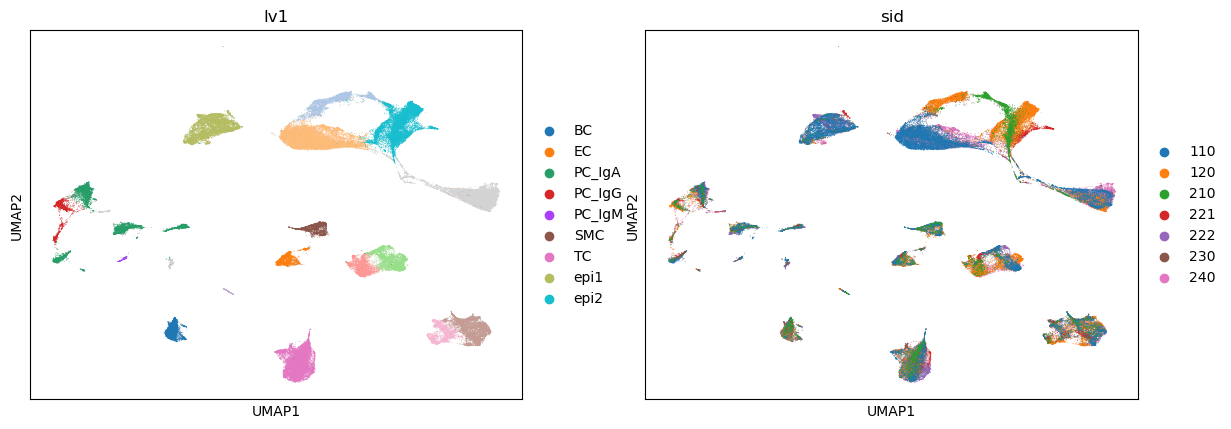

In [9]:
sc.pl.umap(adata, color = ['lv1', 'sid'])

In [10]:
adata.write("/home/augusta/SSS_mount/insituCNV/data/WTx-CosMx_TVA/round2/snPATHOseq/snPATHOseq_prepared.h5ad", compression = 'gzip')

In [12]:
for sid in adata.obs.sid.unique():
    adata_sid = adata[adata.obs.sid == sid].copy()
    dataset_path = f'/home/augusta/SSS_mount/insituCNV/data/WTx-CosMx_TVA/round2/snPATHOseq/snPATHOseq_{sid}.h5ad'
    adata_sid.write(dataset_path, compression = 'gzip')
    print(f'saved dataset {sid}!')

saved dataset 222!
saved dataset 240!
saved dataset 230!
saved dataset 120!
saved dataset 110!
saved dataset 210!
saved dataset 221!


### Add raw data

In [10]:
SIDs = ['110','120','210','221','222','230','242']
for sid in SIDs:
    
    adata_raw = sc.read(f"/home/augusta/SSS_mount/insituCNV/data/WTx-CosMx_TVA/round2/snPATHOseq/snPATHOseq_raw_{sid}.h5ad")
    adata = sc.read(f"/home/augusta/SSS_mount/insituCNV/data/WTx-CosMx_TVA/round2/snPATHOseq/snPATHOseq_{sid}.h5ad")

    adata.obs['barcode'] = adata.obs_names.str.split('.', n=1).str[1].str.split('-', n=1).str[0] + '-1'

    # Ensure that the gene names in adata_a and adata are aligned
    common_genes = adata_raw.var_names.intersection(adata.var.ensembl_id)

    # Subset both datasets to match the common genes
    adata_raw = adata_raw[:, common_genes]  # Keep only the common genes in adata
    adata = adata[:, adata.var.ensembl_id.isin(common_genes)]  # Keep only the common genes in adata_a

    # Ensure that the cell barcodes in adata_a and adata are aligned
    common_barcodes = pd.Index(adata_raw.obs['Barcode']).intersection(adata.obs['barcode'])

    # Subset both datasets to match the common genes
    adata_raw = adata_raw[adata_raw.obs['Barcode'].isin(common_barcodes), :]  # Keep only the common barcodes in adata
    adata = adata[adata.obs['barcode'].isin(common_barcodes), :]  # Keep only the common barcodes in adata_a
    
    adata.layers['raw'] = adata_raw.X  # Assuming raw data is in X, otherwise adjust accordingly

    adata.write(f"/home/augusta/insituCNV/snPATHOseq_{sid}.h5ad")